# Part - 1: Training the model

In [30]:
import torch
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor
from torchvision.datasets import MNIST
from torch import nn
from torch import flatten
from torch.nn import Module, Conv2d, ReLU, MaxPool2d, Linear, BatchNorm2d, Dropout, Softmax
from torch.optim import Adam

from sklearn.metrics import classification_report
from torch.utils.data import random_split

import matplotlib.pyplot as plt
import numpy as np
import time

from torchsummary import summary

In [31]:
class LeNet(Module):
	def __init__(self, numChannels, classes):
		super(LeNet, self).__init__()

		self.conv1 = Conv2d(in_channels=numChannels, out_channels=20, kernel_size=(5, 5))
		self.relu1 = ReLU()
		self.maxpool1 = MaxPool2d(kernel_size=(2, 2), stride=(2, 2))

		self.conv2 = Conv2d(in_channels=20, out_channels=50,
			kernel_size=(5, 5))
		self.relu2 = ReLU()
		self.maxpool2 = MaxPool2d(kernel_size=(2, 2), stride=(2, 2))

		self.fc1 = Linear(in_features=800, out_features=500)
		self.relu3 = ReLU()
		self.dropout1 = Dropout(p=0.1)

		self.fc2 = Linear(in_features=500, out_features=500)
		self.relu4 = ReLU()
		self.dropout2 = Dropout(p=0.1)

		# initialize our softmax classifier
		self.fc3 = Linear(in_features=500, out_features=classes)
		self.Softmax = Softmax(dim=1)

	def forward(self, x):
		x = self.maxpool1(self.relu1(self.conv1(x)))
		x = self.maxpool2(self.relu2(self.conv2(x)))
		x = self.dropout1(self.relu3(self.fc1(flatten(x, 1))))
		x = self.dropout2(self.relu4(self.fc2(x)))
		output = self.Softmax(self.fc3(x))
		return output

In [33]:
INIT_LR = 1e-03
BATCH_SIZE = 64
EPOCHS = 20

# Data split
TRAIN_SPLIT = 0.75
VAL_SPLIT = 1 - TRAIN_SPLIT

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load training dataset
train_data = MNIST(root="data", train=True, download=True, transform=ToTensor())
test_data = MNIST(root="data", train=False, download=True, transform=ToTensor())

# split train/val
train_num = int(len(train_data) * TRAIN_SPLIT)
val_num = int(len(train_data) * VAL_SPLIT)

(train_data, val_data) = random_split(train_data, [train_num, val_num], generator=torch.Generator().manual_seed(14))

# Initialize dataloaders
trainDL = DataLoader(train_data, shuffle=True, batch_size=BATCH_SIZE)
valDL = DataLoader(val_data, batch_size=BATCH_SIZE)
testDL = DataLoader(test_data, batch_size=BATCH_SIZE)

train_step = len(trainDL.dataset) // BATCH_SIZE
val_step = len(valDL.dataset) // BATCH_SIZE

In [34]:
# Initialize the model
model = LeNet(numChannels = 1, classes=len(train_data.dataset.classes)).to(device)
summary(model, (1, 28, 28))
optm = Adam(model.parameters(), lr=INIT_LR)
loss_fn = nn.CrossEntropyLoss()

# for plotting the performance later
history = {
	"train_loss": [],
	"train_acc": [],
	"val_loss": [],
	"val_acc": []
}

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 20, 24, 24]             520
              ReLU-2           [-1, 20, 24, 24]               0
         MaxPool2d-3           [-1, 20, 12, 12]               0
            Conv2d-4             [-1, 50, 8, 8]          25,050
              ReLU-5             [-1, 50, 8, 8]               0
         MaxPool2d-6             [-1, 50, 4, 4]               0
            Linear-7                  [-1, 500]         400,500
              ReLU-8                  [-1, 500]               0
           Dropout-9                  [-1, 500]               0
           Linear-10                  [-1, 500]         250,500
             ReLU-11                  [-1, 500]               0
          Dropout-12                  [-1, 500]               0
           Linear-13                   [-1, 10]           5,010
          Softmax-14                   

In [35]:
# training
time_start = time.time()

for e in range(0, EPOCHS):
  model.train()

  total_tloss = 0 # training loss
  total_vloss = 0 # validation loss

  train_correct = 0
  val_correct = 0

  for (x, y) in trainDL:
    (x, y) = (x.to(device), y.to(device))
    prediction = model(x)
    loss = loss_fn(prediction, y)

    optm.zero_grad()
    loss.backward()
    optm.step()

    total_tloss += loss
    train_correct += (prediction.argmax(1) == y).type(torch.float).sum().item()

  # evaluate model and save
  with torch.no_grad():
    for (x, y) in valDL:
      (x, y) = (x.to(device), y.to(device))
      prediction = model(x)
      total_vloss += loss_fn(prediction, y)

      val_correct += (prediction.argmax(1) == y).type(torch.float).sum().item()

  # average training and validation loss
  avg_tloss = total_tloss / train_step
  avg_vloss = total_vloss / val_step

  # training and validation accuracy
  train_correct = train_correct / len(trainDL.dataset)
  val_correct = val_correct / len(valDL.dataset)

  # update training
  history["train_loss"].append(avg_tloss.cpu().detach().numpy())
  history["train_acc"].append(train_correct)
  history["val_loss"].append(avg_vloss.cpu().detach().numpy())
  history["val_acc"].append(val_correct)

  # print training info
  print(f"EPOCH: {e+1}/{EPOCHS}, Train Loss: {avg_tloss:.4f}, Train Accuracy: {train_correct:.4f}, Validation Loss:{avg_vloss:0.4f}, Validation Accuracy: {val_correct:0.4f}")

  # if (e+1) % 10 == 0:
  #   model.eval()
  #   torch.save(model, "model_" + str(e+1) + ".pth")
  #   print(f"Model saved at epoch: {e+1}")

time_end = time.time()
print(f"Training Time: {(time_end - time_start):.2f}s")

EPOCH: 1/50, Train Loss: 1.5642, Train Accuracy: 0.9027, Validation Loss:1.5002, Validation Accuracy: 0.9677
EPOCH: 2/50, Train Loss: 1.4930, Train Accuracy: 0.9706, Validation Loss:1.4967, Validation Accuracy: 0.9711
EPOCH: 3/50, Train Loss: 1.4877, Train Accuracy: 0.9759, Validation Loss:1.4938, Validation Accuracy: 0.9733
EPOCH: 4/50, Train Loss: 1.4826, Train Accuracy: 0.9809, Validation Loss:1.4878, Validation Accuracy: 0.9799
EPOCH: 5/50, Train Loss: 1.4831, Train Accuracy: 0.9801, Validation Loss:1.4883, Validation Accuracy: 0.9792
EPOCH: 6/50, Train Loss: 1.4820, Train Accuracy: 0.9814, Validation Loss:1.4866, Validation Accuracy: 0.9807
EPOCH: 7/50, Train Loss: 1.4828, Train Accuracy: 0.9804, Validation Loss:1.4891, Validation Accuracy: 0.9781
EPOCH: 8/50, Train Loss: 1.4801, Train Accuracy: 0.9831, Validation Loss:1.4876, Validation Accuracy: 0.9797
EPOCH: 9/50, Train Loss: 1.4792, Train Accuracy: 0.9840, Validation Loss:1.4891, Validation Accuracy: 0.9784
EPOCH: 10/50, Train

In [36]:
# Testing the network
with torch.no_grad():
  model.eval()
  prediction_list = []

  for (x, y) in testDL:
    x = x.to(device)
    prediction = model(x)
    prediction_list.extend(prediction.argmax(axis=1).cpu().numpy())

  print(classification_report(test_data.targets.cpu().numpy(), np.array(prediction_list), target_names=test_data.classes))

              precision    recall  f1-score   support

    0 - zero       0.98      0.99      0.98       980
     1 - one       0.97      1.00      0.98      1135
     2 - two       1.00      0.96      0.98      1032
   3 - three       0.99      0.98      0.98      1010
    4 - four       1.00      0.96      0.98       982
    5 - five       0.99      0.98      0.98       892
     6 - six       0.99      0.97      0.98       958
   7 - seven       0.97      0.99      0.98      1028
   8 - eight       0.98      0.97      0.97       974
    9 - nine       0.93      0.98      0.96      1009

    accuracy                           0.98     10000
   macro avg       0.98      0.98      0.98     10000
weighted avg       0.98      0.98      0.98     10000



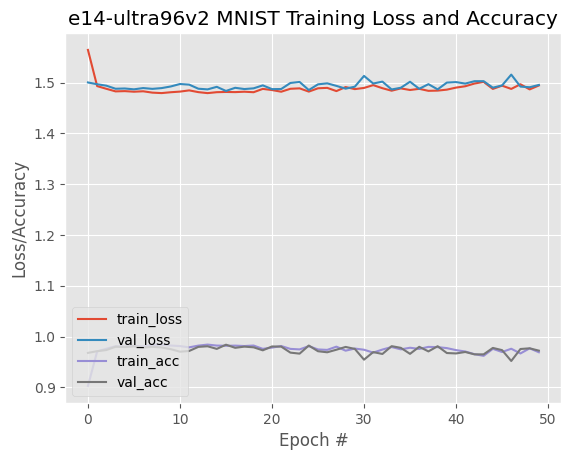

In [37]:
plt.style.use("ggplot")
plt.figure()
plt.plot(history["train_loss"], label="train_loss")
plt.plot(history["val_loss"], label="val_loss")
plt.plot(history["train_acc"], label="train_acc")
plt.plot(history["val_acc"], label="val_acc")
plt.title("e14-ultra96v2 MNIST Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.show()

In [38]:
# Save the model
torch.save(model, "model.pth")

# Part - 2: Export to ONNX

In [39]:
!pip3 install onnx
import torch.onnx

In [40]:
model.eval()
dummy_input = torch.randn(1, 1, 28, 28, requires_grad=True).to(device)

output_model = "e14_mnist_" + str(EPOCHS)+ "_tacc_" +str(int(train_correct*100))+".onnx"

torch.onnx.export(model,
                  dummy_input,
                  output_model,
                  export_params=True,
                  opset_version=10,
                  do_constant_folding=True,
                  input_names = ['x:0'],
                  output_names = ['Identity:0'])

============= Diagnostic Run torch.onnx.export version 2.0.1+cu118 =============
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================

